In [1]:

import matplotlib
matplotlib.use('Agg')

import os
import json
import sys
import h5py
import itertools
import optparse
import pprint
import traceback
import pylab as pl
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

from pipeline.python.utils import natural_keys, replace_root
from pipeline.python.traces.utils import load_TID, get_metric_set
from pipeline.python.paradigm.align_acquisition_events import get_stimulus_configs, set_pupil_params
pp = pprint.PrettyPrinter(indent=4)


In [2]:
%matplotlib notebook

In [3]:
def extract_options(options):

    choices_tracetype = ('raw', 'raw_fissa', 'denoised_nmf', 'np_corrected_fissa', 'neuropil_fissa', 'np_subtracted', 'neuropil')
    default_tracetype = 'raw'

    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/nas/volume1/2photon/data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='', help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('--slurm', action='store_true', dest='slurm', default=False, help="set if running as SLURM job on Odyssey")
    parser.add_option('--default', action='store_true', dest='auto', default=False, help="set if want to use all defaults")

    parser.add_option('-t', '--trace-id', action='store', dest='trace_id', default='', help="Trace ID for current trace set (created with set_trace_params.py, e.g., traces001, traces020, etc.)")
    parser.add_option('-T', '--trace-type', type='choice', choices=choices_tracetype, action='store', dest='trace_type', default=default_tracetype, help="Type of timecourse to plot PSTHs. Valid choices: %s [default: %s]" % (choices_tracetype, default_tracetype))

    # Pupil filtering info:
    parser.add_option('--no-pupil', action="store_false",
                      dest="filter_pupil", default=True, help="Set flag NOT to filter PSTH traces by pupil threshold params")
    parser.add_option('-s', '--radius-min', action="store",
                      dest="pupil_radius_min", default=25, help="Cut-off for smnallest pupil radius, if --pupil set [default: 25]")
    parser.add_option('-B', '--radius-max', action="store",
                      dest="pupil_radius_max", default=65, help="Cut-off for biggest pupil radius, if --pupil set [default: 65]")
    parser.add_option('-d', '--dist', action="store",
                      dest="pupil_dist_thr", default=15, help="Cut-off for pupil distance from start, if --pupil set [default: 5]")

    (options, args) = parser.parse_args(options)

    return options

In [230]:
options = ['-D', '/mnt/odyssey', '-i', 'JR081', '-S', '20180502',
        '-A', 'FOV2_zoom1x', '-R', 'blobs_run1', '-t', 'traces002',
        '--no-pupil',
        '-T', 'np_subtracted']

# options = ['-D', '/mnt/odyssey', '-i', 'CE077', '-S', '20180425',
#         '-A', 'FOV2_zoom1x', '-R', 'blobs_run1', '-t', 'traces001',
#         '--no-pupil',
#         '-T', 'np_subtracted']

In [231]:
options = extract_options(options)

rootdir = options.rootdir
slurm = options.slurm
if slurm is True and 'coxfs01' not in rootdir:
    rootdir = '/n/coxfs01/2p-data'
animalid = options.animalid
session = options.session
acquisition = options.acquisition
run = options.run
trace_id = options.trace_id
trace_type = options.trace_type
auto = options.auto

filter_pupil = options.filter_pupil
pupil_radius_max = float(options.pupil_radius_max)
pupil_radius_min = float(options.pupil_radius_min)
pupil_dist_thr = float(options.pupil_dist_thr)


In [232]:


# Get acquisition info:
run_dir = os.path.join(rootdir, animalid, session, acquisition, run)

# Load TRACE ID info:
# =========================================================================
TID = load_TID(run_dir, trace_id)
traceid_dir = TID['DST']
if rootdir not in traceid_dir:
    orig_root = traceid_dir.split('/%s/%s' % (animalid, session))[0]
    traceid_dir = traceid_dir.replace(orig_root, rootdir)
    print "Replacing orig root with dir:", traceid_dir
    #trace_hash = TID['trace_hash']


USING TRACE ID: traces002
{   u'DST': u'/n/coxfs01/2p-data/JR081/20180502/FOV2_zoom1x/blobs_run1/traces/traces002_104a04',
    u'PARAMS': {   u'excluded_tiffs': [],
                   u'hashid': u'f69c5a',
                   u'nonnegative': False,
                   u'rid_hash': u'af9691',
                   u'roi_id': u'rois004',
                   u'roi_type': u'manual2D_circle',
                   u'signal_channel': 1,
                   u'tiff_source': u'/n/coxfs01/2p-data/JR081/20180502/FOV2_zoom1x/blobs_run1/processed/processed001_ac120b/mcorrected_8878fa',
                   u'uint16': False,
                   u'unsigned': False},
    u'SRC': u'/n/coxfs01/2p-data/JR081/20180502/FOV2_zoom1x/blobs_run1/processed/processed001_ac120b/mcorrected_8878fa',
    u'trace_hash': u'104a04',
    u'trace_id': u'traces002',
    u'version': u'0.1.0'}
Replacing orig root with dir: /mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/traces/traces002_104a04


In [233]:
event_info_fpath = [os.path.join(traceid_dir, f) for f in os.listdir(traceid_dir) if 'event_alignment' in f and f.endswith('json')][0]
with open(event_info_fpath, 'r') as f:
    trial_info = json.load(f)
if rootdir not in trial_info['parsed_trials_source']:
    trial_info['parsed_trials_source'] = replace_root(trial_info['parsed_trials_source'], rootdir, animalid, session)
configs, stimtype = get_stimulus_configs(trial_info)



# Load particular metrics set:
selected_metric = get_metric_set(traceid_dir, filter_pupil=filter_pupil,
                                     pupil_radius_min=pupil_radius_min,
                                     pupil_radius_max=pupil_radius_max,
                                     pupil_dist_thr=pupil_dist_thr
                                     )

# Load associated pupil_params set:
with open(os.path.join(traceid_dir, 'metrics', selected_metric, 'pupil_params.json'), 'r') as f:
    pupil_params = json.load(f)
pp.pprint(pupil_params)

# Set paths toi ROIDATA_, roi_metrics_, and roi_stats_:
roistats_filepath = [os.path.join(traceid_dir, 'metrics', selected_metric, f)
                        for f in os.listdir(os.path.join(traceid_dir, 'metrics', selected_metric))
                        if 'roi_stats_' in f and trace_type in f and f.endswith('hdf5')][0]

roidata_filepath = [os.path.join(traceid_dir, f)
                        for f in os.listdir(traceid_dir)
                        if 'ROIDATA_' in f and trace_type in f and f.endswith('hdf5')][0]

ORIG ROOT: /mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/paradigm/trials_17d8a1.json
NEW ROOT: /mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/paradigm/trials_17d8a1.json
---> Found 25 unique stimulus configs.
Selected metric: unfiltered_2513448523829438896
Use?  Press <Y> to confirm, <n> to reset: Y
{   u'dist_thr': None,
    u'hash': 2513448523829438896,
    u'max_nblinks': None,
    u'radius_max': None,
    u'radius_min': None}


# Load data

In [234]:
from pipeline.python.visualization import plot_psths_from_dataframe as vis

In [235]:
DATA = pd.HDFStore(roidata_filepath, 'r')

transform_dict, object_transformations = vis.get_object_transforms(DATA[DATA.keys()[0]])

roi_list = sorted(DATA.keys(), key=natural_keys)

In [236]:
# ROI from CE077_20180425 - FOV1_zoom1x, traces002 (r3)
# roi = 'roi00003'
# xpos = -28.0
# ypos = -2.0

# ROI from CE077_20180425 - FOV2_zoom1x, traces001 (r47)
# roi = 'roi00047'
# xpos = 4.0
# ypos = -2.0

# ROI from JR081_2018502 - FOV2_zoom1x, traces002 (r90)
roi = 'roi00090'
xpos = -28.0
ypos = -10.0

# roi = 'roi00040'
# xpos = -8.0
# ypos = -10.0

In [237]:
D = DATA[roi]

In [238]:
D.keys()

Index([u'config', u'df', u'first_on', u'nframes_on', u'nsecs_on', u'raw',
       u'roi_in_slice', u'size', u'slice', u'trial', u'tsec', u'xpos', u'ypos',
       u'morphlevel', u'object', u'yrot'],
      dtype='object')

In [239]:
first_on = list(set(D['first_on']))[0]
nframes_on =int(round(list(set(D['nframes_on']))[0]))

print nframes_on
print first_on


45
45


In [240]:
df = D[( (D['xpos']==xpos) & (D['ypos']==ypos) )][['trial', 'morphlevel', 'tsec', 'df', 'raw']]

In [241]:
df.head()

,trial,morphlevel,tsec,df,raw
0,trial00022,0,-1.008447,-0.527452,137.446494
1,trial00022,0,-0.986037,-0.442513,162.151821
2,trial00022,0,-0.963628,0.130729,328.886417
3,trial00022,0,-0.941218,0.667374,484.976377
4,trial00022,0,-0.918808,-0.366769,184.183180


In [242]:
morph_levels = sorted(list(set(df['morphlevel'])))
print morph_levels

[0, 5, 11, 16, 22]


In [219]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth_traces(trace, frac=0.002):
    '''
    lowess algo (from docs):

    Suppose the input data has N points. The algorithm works by estimating the
    smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their
    x values and estimating y_i using a weighted linear regression. The weight
    for (x_j,y_j) is tricube function applied to abs(x_i-x_j).
    '''
    xvals = np.arange(len(trace))
    filtered = lowess(trace, xvals, is_sorted=True, frac=frac, it=0)
    return filtered[:, 1]



#### Look at one morph level first:

In [150]:
morph = 5

In [151]:
dfmat = np.vstack([t for t in df[df['morphlevel']==morph].groupby(['trial'])['df'].apply(np.array).values]) #.shape
tsecmat = np.vstack([t for t in df[df['morphlevel']==morph].groupby(['trial'])['tsec'].apply(np.array).values])
print dfmat.shape

(10, 179)


In [160]:
filtered_dfmat = np.apply_along_axis(smooth_traces, 1, dfmat, frac=0.1)


<IPython.core.display.Javascript object>


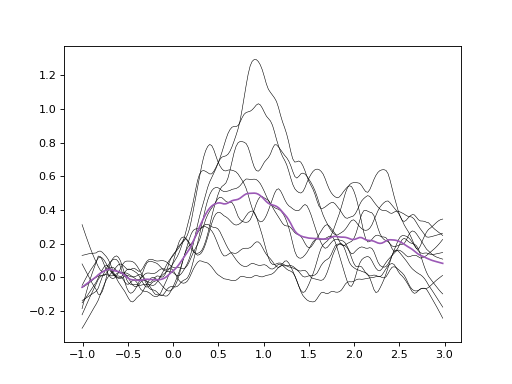

In [161]:
pl.figure()
for t in range(dfmat.shape[0]):
    pl.plot(tsecmat[t,:], filtered_dfmat[t,:], 'k', linewidth=0.5)
average_tsec = np.mean(tsecmat, axis=0)
average_trace = np.mean(filtered_dfmat, axis=0)
pl.plot(average_tsec, average_trace)

<IPython.core.display.Javascript object>


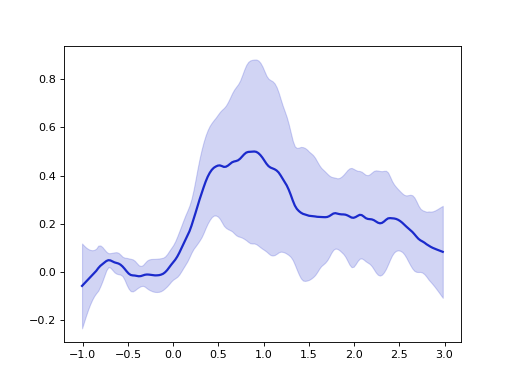

In [162]:
pl.figure()

average_tsec = np.mean(tsecmat, axis=0)
average_trace = np.mean(filtered_dfmat, axis=0)
yerr_trace = np.std(filtered_dfmat, axis=0)

pl.plot(average_tsec, average_trace, color='#1B2ACC', linewidth=2)
pl.fill_between(average_tsec, average_trace-yerr_trace, average_trace+yerr_trace, alpha=0.2,
                   edgecolor='#1B2ACC', facecolor='#1B2ACC')


<IPython.core.display.Javascript object>


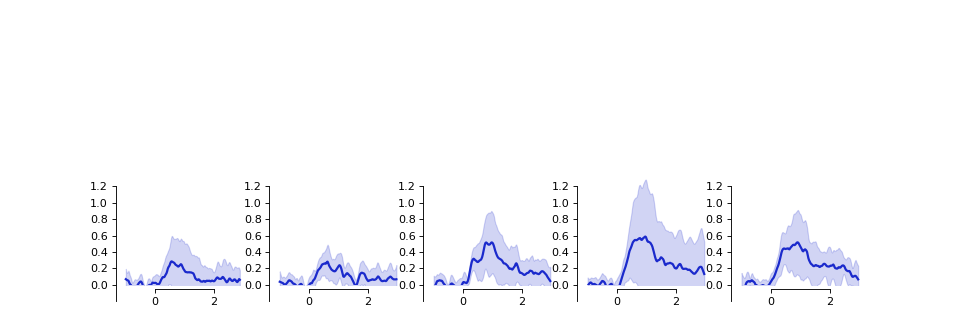

In [163]:
fig, axes = pl.subplots(1,len(morph_levels), sharex=True, sharey=True, figsize=(12,4))
for mi, morph in enumerate(morph_levels):
    ax = axes[mi]
    dfmat = np.vstack([t for t in df[df['morphlevel']==morph].groupby(['trial'])['df'].apply(np.array).values]) #.shape
    tsecmat = np.vstack([t for t in df[df['morphlevel']==morph].groupby(['trial'])['tsec'].apply(np.array).values])
    #print dfmat.shape
    filtered_dfmat = np.apply_along_axis(smooth_traces, 1, dfmat, frac=0.06)
    
    average_tsec = np.mean(tsecmat, axis=0)
    average_trace = np.mean(filtered_dfmat, axis=0)
    yerr_trace = np.std(filtered_dfmat, axis=0)

    ax.plot(average_tsec, average_trace, color='#1B2ACC', linewidth=2)
    ax.fill_between(average_tsec, average_trace-yerr_trace, average_trace+yerr_trace, alpha=0.2,
                       edgecolor='#1B2ACC', facecolor='#1B2ACC')
#     if mi > 0:
#         print mi
#         ax.set_ylabel('')
#         ax.set_yticks(())
#         sns.despine(offset=4, trim=True)
#     else:
#         ax.set_ylabel(ax.get_ylabel())
#         ax.set_yticks(ax.get_yticks())

sns.despine(offset=4, trim=True, )

   

# Plot tuning curves:

In [243]:
STATS = pd.HDFStore(roistats_filepath, 'r')['/df']


In [244]:
roiDF = STATS[STATS['roi'] == '/%s' % roi]

   xpos  morphlevel    zscore
0 -28.0           0  0.724969
1 -28.0           5  1.521245
2 -28.0          11  0.880948
3 -28.0          16  1.005225
4 -28.0          22  0.703345


<IPython.core.display.Javascript object>


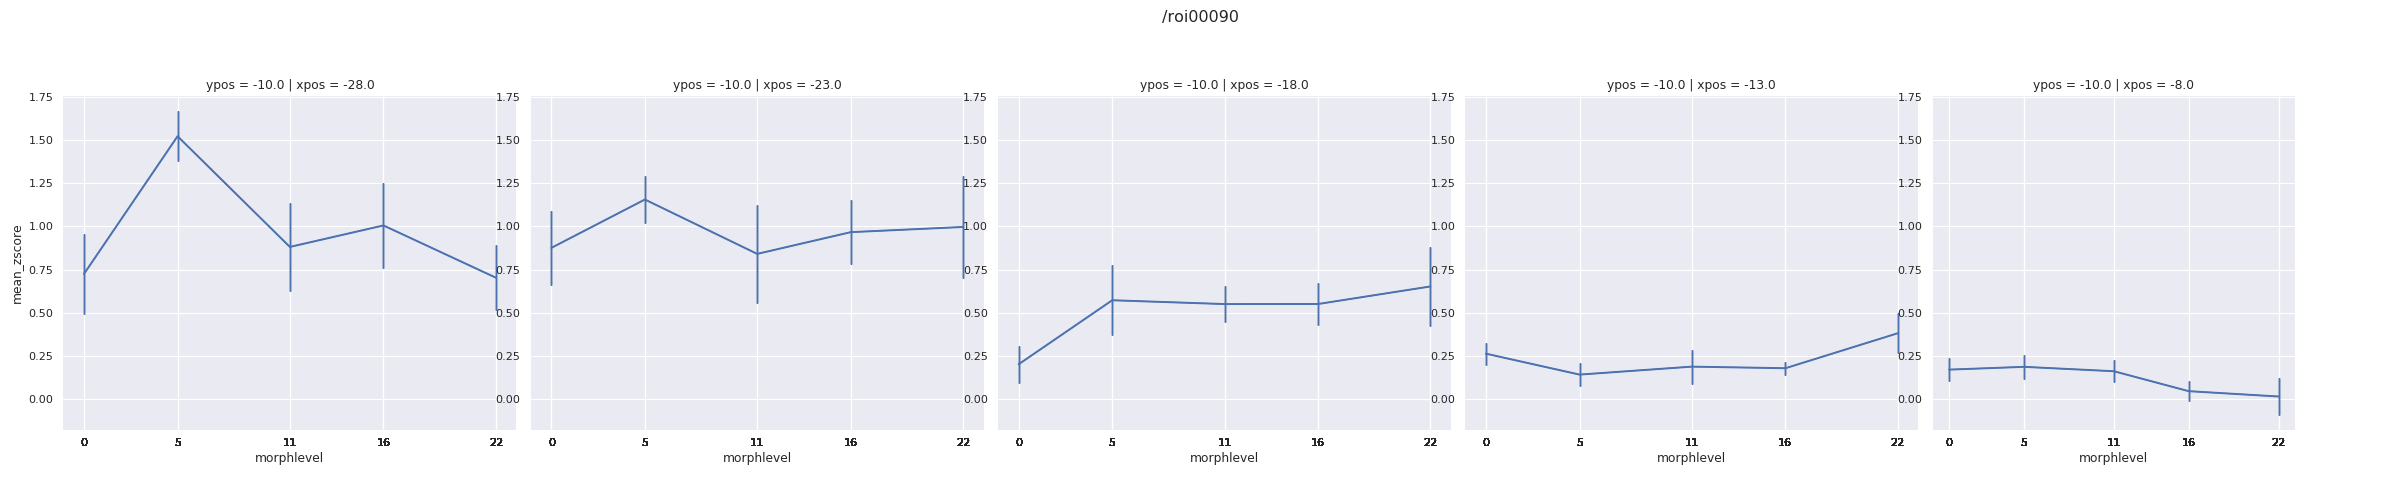

['grid_xypos_morphlevel_tuning_zscore_roi00090.png']

In [245]:
vis.plot_tuning_by_transforms(roiDF, transform_dict, object_transformations, metric_type='zscore',
                              save_and_close=False, include_trials=False)

In [252]:
figdir = os.path.join(TID['DST'], 'figures', 'tuning', 'good_quality')
if rootdir not in figdir:
    figdir = replace_root(figdir, rootdir, animalid, session)
if not os.path.exists(figdir):
    os.makedirs(figdir)

ORIG ROOT: /mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/traces/traces002_104a04/figures/tuning/good_quality
NEW ROOT: /mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/traces/traces002_104a04/figures/tuning/good_quality


In [191]:
pl.savefig(os.path.join(figdir, 'tuning_%s.pdf' % roi))

In [246]:
metric_type = 'zscore'

In [247]:
stim_subsets = False

roi = list(set(roiDF['roi']))[0]

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
cmapcolors = itertools.cycle(sns.xkcd_palette(colors))

trans_types = object_transformations.keys()

# Grid x,y positions, and vary other trans_type(s??) as curves:
grid_variables = ['xpos', 'ypos']
nrows = len(transform_dict['ypos'])
rows = 'ypos'
row_order = sorted(list(set(roiDF['ypos'])))[::-1]

ncols = len(transform_dict['xpos'])
columns = 'xpos'
col_order = sorted(list(set(roiDF['xpos'])))

other_trans_types = [t for t in object_transformations.keys() if not t in grid_variables]
desc = 'grid_xypos_%s' % '_'.join(other_trans_types)

if len(other_trans_types) == 1:
    xval_trans = other_trans_types[0]
    hue_trans = None

elif 'ori' in other_trans_types and 'sf' in other_trans_types:
    xval_trans = 'ori'   # Plot orientation along x-axis
    hue_trans = 'sf'     # Set hue by spatial frequency

elif 'morphlevel' in other_trans_types and ('yrot' in other_trans_types or 'size' in other_trans_types):
    # Actually want to plot a figure for EACH transform...
    desc = {}
    hues = {}
    stim_subsets = True
    plotconfig = []
    for trans_type in other_trans_types:
        desc[trans_type] = 'grid_xypos_%s' % trans_type
        hues[trans_type] = {}
        trans_vals = roiDF.groupby([trans_type]).groups.keys()                                      # Get all values of current trans_type
        comparison_trans_types = [i for i in other_trans_types if not i == trans_type]           # Identify which other transform there is (only 2)
        for comp_trans in comparison_trans_types:
            vals_bytrans = [list(set(roiDF[roiDF[trans_type]==tr][comp_trans])) for tr in trans_vals]  # Get other-transform vals for each value of current trans_type
            all_vals = list(set(list(itertools.chain.from_iterable(vals_bytrans))))
            common_vals = list(reduce(set.intersection, map(set, vals_bytrans)))                  # Only include other-trans vals common to all vals of trans_type

#                if not len(common_vals) == len(all_vals):
#                    stim_subsets = True
#                else:
#                    stim_subsets = False
            plotconfig.append(stim_subsets)
            hues[trans_type][comp_trans] = common_vals



# Set up colors for transforms with multiple combos with other transforms
color_dict = {}
if stim_subsets is True:
    # There multiple transforms we want for the 'x-axis' in a given subplot
    for xval_trans in hues.keys():
        for comp_trans in hues[xval_trans].keys():
            comparison_values = hues[xval_trans][comp_trans]
            color_dict[xval_trans] = [next(cmapcolors) for v in comparison_values]
else:
    # There is only one main transform to look at, with the other trans
    # denoted by hue
    if hue_trans is not None:
        comparison_values = list(set(roiDF[hue_trans]))
        color_dict[xval_trans] = [next(cmapcolors) for v in comparison_values] #'xkcd:%s' % cmapcolors[t]
    else:
        color_dict[xval_trans] = [next(cmapcolors)]


# Append summary stats for metric_type = 'zscore' to dataframe for plotting:

dfz = roiDF[np.isfinite(roiDF[metric_type])]     # Get rid of NaNs
plot_variables = list(trans_types)      # List of transforms (variables-of-interest) to pull from dataframe (e.g.,'ori')
plot_variables.extend([metric_type])    # Append metric to show in list of variables-of-interest
if 'xpos' not in plot_variables:
    plot_variables.extend(['xpos'])
if 'ypos' not in plot_variables:
    plot_variables.extend(['ypos'])

dfz = dfz[plot_variables]               # Get subset dataframe of variables-of-interest
dfz = dfz.reset_index()

grouped = dfz.groupby(trans_types, as_index=False)                         # Group dataframe subset by variables-of-interest
zscores = grouped.zscore.mean()                                            # Get mean of 'metric_type' for each combination of transforms
print zscores.head()
if len(trans_types) > 1:
    zscores['sem'] = grouped.zscore.aggregate(stats.sem)[metric_type]             # Get SEM
else:
    zscores['sem'] = grouped.zscore.apply(stats.sem)


zscores = zscores.rename(columns={metric_type: 'mean_%s' % metric_type})                # Rename 'zscore' column to 'mean_zscore' so we can merge
dfz = dfz.merge(zscores).sort_values([xval_trans])                         # Merge summary stats to each corresponding row (indexed by columns values in that row)


   xpos  morphlevel    zscore
0 -28.0           0  0.724969
1 -28.0           5  1.521245
2 -28.0          11  0.880948
3 -28.0          16  1.005225
4 -28.0          22  0.703345


In [248]:
color_dict.keys()
print stim_subsets
print desc

False
grid_xypos_morphlevel


<IPython.core.display.Javascript object>


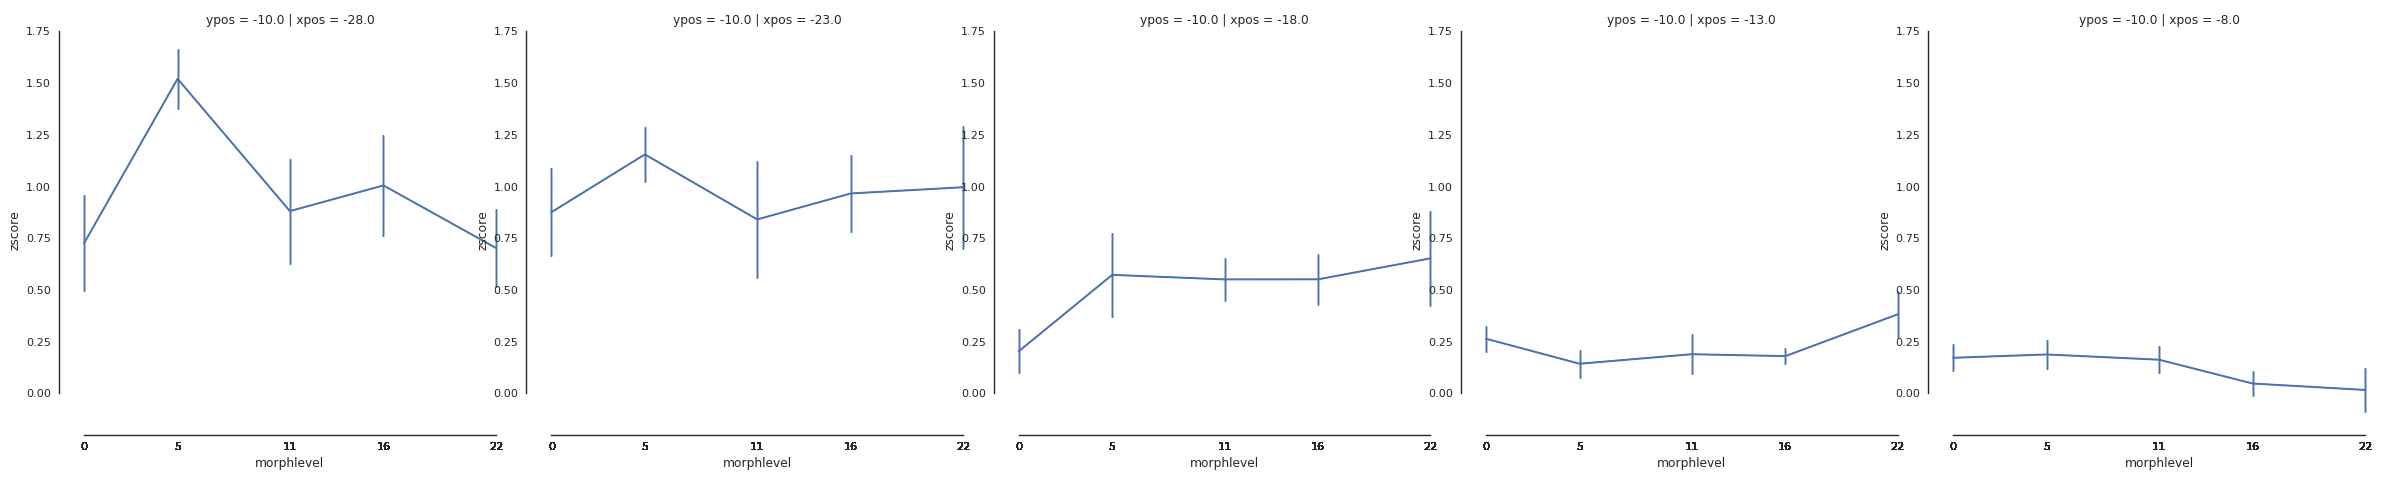

(0, 3.0)

In [255]:

# Plot tuning curves:

xval_trans = 'morphlevel'

if isinstance(desc, str):
    transform_str = desc


plotdf = dfz.copy()
sns.set_style('white')

g1 = sns.FacetGrid(plotdf.sort_values([xval_trans]), row=rows, col=columns, sharex=True, sharey=True,
                       hue=hue_trans, row_order=row_order, col_order=col_order,
                       legend_out=True, size=6)

g1.map(pl.plot, xval_trans, 'mean_%s' % metric_type, marker="_", linestyle='-')
g1.map(pl.errorbar, xval_trans, 'mean_%s' % metric_type, 'sem', elinewidth=1, linewidth=1)
g1.set(xticks=sorted(plotdf[xval_trans]))
g1.set(ylabel='zscore')
# if include_trials:
#     g1.map(pl.scatter, xval_trans, metric_type, s=1.0)

#     # Format ticks, title, etc.
#     g1.set(xticks=sorted(plotdf[xval_trans]))
#     sns.despine(offset=2, trim=True, bottom=True)
#     pl.subplots_adjust(top=0.8)
#     g1.fig.suptitle(roi)

#     # resize figure box to -> put the legend out of the figure
#     if hasattr(g1, 'ax'):
#         box = g1.ax.get_position() # get position of figure
#         g1.ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]) # resize position
#         g1.ax.legend(loc='center right', bbox_to_anchor=(1.2, 0.8), ncol=1)
#     else:
#         box = g1.facet_axis(-1, -1).get_position() # get position of figure
#         g1.facet_axis(-1, -1).set_position([box.x0, box.y0, box.width * 0.8, box.height]) # resize position
#         g1.facet_axis(-1, -1).legend(loc='center right', bbox_to_anchor=(1.2, 0.8), ncol=1)
#     if '/' in roi:
#         roi = roi[1:]

#     if include_trials is True:
#         figname = '%s_tuning_%s_trials_%s.png' % (transform_str, metric_type, roi)
#     else:
#         figname = '%s_tuning_%s_%s.png' % (transform_str, metric_type, roi)
sns.despine(offset=4, trim=True)
ax.set_ylim(0, 3.0)

In [200]:
sns.despine(offset=4, trim=True)

In [253]:
pl.savefig(os.path.join(figdir, 'tuning_%s.pdf' % roi[1:]))

In [254]:
print figdir

/mnt/odyssey/JR081/20180502/FOV2_zoom1x/blobs_run1/traces/traces002_104a04/figures/tuning/good_quality
